In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"ericchuangg","key":"ceda6997e41469f9bf4b0b734ae977a9"}')  # TODO: Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73272 sha256=9c9f2abdf10cfa0c3ad89f12caf270e7957587db3992eb4060fc38ffb07a48ba
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.13
    Uninstalling kaggle-1.5.13:
      Successfully uninstalled kaggle-1.5.13


In [3]:
!kaggle datasets download -d paultimothymooney/stock-market-data

 98% 1.02G/1.03G [00:11<00:00, 107MB/s]
100% 1.03G/1.03G [00:11<00:00, 99.6MB/s]


In [4]:
!unzip stock-market-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: stock_market_data/nasdaq/json/CLNT.json  
  inflating: stock_market_data/nasdaq/json/CLRB.json  
  inflating: stock_market_data/nasdaq/json/CLRI.json  
  inflating: stock_market_data/nasdaq/json/CLRO.json  
  inflating: stock_market_data/nasdaq/json/CLRX.json  
  inflating: stock_market_data/nasdaq/json/CLTX.json  
  inflating: stock_market_data/nasdaq/json/CLVS.json  
  inflating: stock_market_data/nasdaq/json/CLWT.json  
  inflating: stock_market_data/nasdaq/json/CLYAF.json  
  inflating: stock_market_data/nasdaq/json/CMCO.json  
  inflating: stock_market_data/nasdaq/json/CMCSA.json  
  inflating: stock_market_data/nasdaq/json/CMCT.json  
  inflating: stock_market_data/nasdaq/json/CME.json  
  inflating: stock_market_data/nasdaq/json/CMGE.json  
  inflating: stock_market_data/nasdaq/json/CMLS.json  
  inflating: stock_market_data/nasdaq/json/CMOXF.json  
  inflating: stock_market_data/nasdaq/json/CMPR.json  
  inflating:

In [5]:
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
class CSVData(Dataset):
    def __init__(self, folder_path, training_length, predict_length):
        self.folder_path = folder_path
        self.training_length = training_length
        self.predict_length = predict_length
        self.files = [f for f in os.listdir(folder_path) if f.endswith('.csv')][:500]
        self.data = []
        self.tickers = []

        for file in self.files:
            csv_file = pd.read_csv(os.path.join(folder_path, file))
            open_col = csv_file['Open'].values
            ticker = file.split('.')[0]
            for i in range(len(open_col) - training_length - predict_length):
                self.data.append((open_col[i:i+training_length], open_col[i+training_length:i+training_length+predict_length], ticker))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        training_data, label_data, ticker = self.data[index]
        training_data = torch.Tensor(training_data)
        label_data = torch.Tensor(label_data)
        # ticker = torch.Tensor(ticker)
        return training_data, label_data, ticker

    def plot_trend(self, batch_data):
        plt.figure(figsize=(10, 5))
        for i in range(batch_data.size(0)):
            x = torch.arange(batch_data.shape[1])
            y = batch_data[i].numpy()  * 100
            plt.plot(x, y, label=f'{self.tickers[i]}')
        plt.xlabel('Days')
        plt.ylabel('Percentage of Original Value')
        plt.title('Stock Trend')
        plt.legend()
        plt.show()

# Example usage
folder_path = "/content/stock_market_data/sp500/csv/"
training_length = 60
predict_length = 30
batch_size = 16

dataset = CSVData(folder_path, training_length, predict_length)
dataloader = DataLoader(dataset, batch_size, shuffle=True)

# Iterate through batches of data
for batch in dataloader:
    training_data, label_data, ticker = batch
    print(training_data.shape, label_data.shape, ticker)
    # dataset.plot_trend(training_data)
    break

torch.Size([16, 60]) torch.Size([16, 30]) ('SRE', 'HAS', 'TMO', 'SYK', 'WST', 'PLD', 'RJF', 'WY', 'IFF', 'ADSK', 'RL', 'A', 'TRV', 'PEG', 'RJF', 'RCL')


torch.Size([8, 60]) torch.Size([8, 30])
[]


<ipython-input-6-9b96e8e015ce>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+list(tickers))
<ipython-input-6-9b96e8e015ce>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+list(tickers))


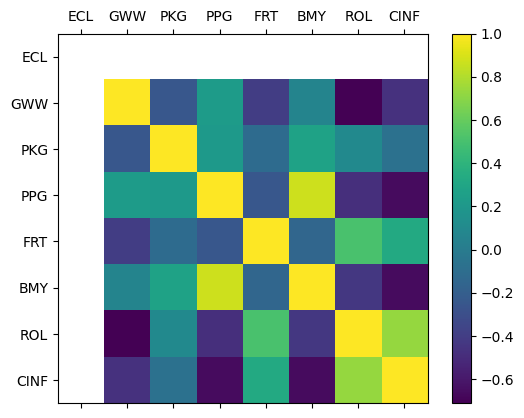

In [6]:
max_seq_len = 100
batch_size = 8

folder_path = "/content/stock_market_data/sp500/csv/"
training_length = 60
predict_length = 30

dataset = CSVData(folder_path, training_length, predict_length)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

import numpy as np

for data in train_loader:
    
    column_data, labels, tickers = data
    print(column_data.shape, labels.shape)
    # train_loader.plot_trend(column_data, column_len)
    corr_matrix = torch.corrcoef(column_data.squeeze(-1))

    # display correlation matrix
    # plt.matshow(corr_matrix, 0)
    print(dataset.tickers)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr_matrix)
    fig.colorbar(cax)
    
    ax.set_xticklabels(['']+list(tickers))
    ax.set_yticklabels(['']+list(tickers))

    plt.show()
    break


In [7]:
# Define hyperparameters
batch_size = 16
learning_rate = 1e-4
hidden_size = 50
training_length = 60
predict_length = 30

train_folder_path = '/content/stock_market_data/sp500/csv/'
test_folder_path = '/content/stock_market_data/nyse/csv/'
train_dataset = CSVData(train_folder_path, training_length, predict_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CSVData(test_folder_path, training_length, predict_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Define the sequence length for input data to the LSTM model
sequence_length = 60
prediction_length = 30

# Define the LSTM model
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, input_size, num_layers, batch_first=True)
        self.linear1 = nn.Linear(seq_len, hidden_size)
        self.fc = nn.Linear(seq_len, prediction_length)
        self.fc1 = nn.Linear(seq_len, seq_len)
        self.fc2 = nn.Linear(seq_len, seq_len)

        self.fc_only_lstm = nn.Linear(hidden_size, prediction_length)
        self.gelu = nn.GELU()
        self.seq_len = seq_len

    def forward(self, x, adj_matrix):
        out, _ = self.lstm(x)
        out2, _ = self.lstm2(out)
        # out2 = out2.reshape(self.seq_len, -1)
        tmp = torch.matmul(adj_matrix, out2)
        # tmp = tmp.reshape(-1, self.seq_len)
        tmp_out = self.fc1(tmp)
        gelu1_out = self.gelu(tmp_out)

        tmp = torch.matmul(adj_matrix, gelu1_out)
        tmp_out = self.fc2(tmp)
        gelu1_out = self.gelu(tmp_out)

        out = self.fc(gelu1_out.reshape(x.shape[0], -1))
        return out


In [15]:
learning_rate = 1e-6
device = 'cuda'

# model = StockLSTM(input_size=60, hidden_size=hidden_size, seq_len=training_length).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss().to(device)
overall_avg_loss = []
overall_test_loss = []

import numpy as np
import pandas as pd

def create_adj_matrix(data, threshold = 0.8):
    """
    Creates an adjacency matrix for a correlation graph given a pandas DataFrame of stock prices and a threshold value.

    :param data: pandas DataFrame of stock prices with each column representing a stock and each row representing a day
    :param threshold: minimum correlation coefficient value for an edge to be included in the graph
    :return: a numpy ndarray representing the adjacency matrix
    """
    # Calculate the correlation matrix
    # print(data.squeeze(-1))
    corr_matrix = torch.corrcoef(data.squeeze(-1))

    nan_indices = torch.isnan(corr_matrix)
    corr_matrix[nan_indices] = 0.0

    # adj_matrix = np.where(np.abs(corr_matrix) >= threshold, 1, 0)
    # return torch.from_numpy(adj_matrix).float()

    return corr_matrix

from tqdm import tqdm
num_epochs = 100

from sklearn.preprocessing import normalize
import numpy as np


def scale(X):
  '''
  Scales each row so that the largest value is 1.0
  '''
  eps = 1e-12
  scaled_X = (X - 0) / (torch.max(X, axis=1).values - 0 + eps).unsqueeze(1)
  return scaled_X, torch.max(X, axis=1).values.unsqueeze(1)

for epoch in range(num_epochs):
    running_loss = 0.0
    # Wrap the train_loader with tqdm for progress bar
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        
        column_data, labels, tickers = data
        optimizer.zero_grad()
        if torch.sum(torch.isnan(column_data)) + torch.sum(torch.isnan(labels))> 0:
          continue

        column_data, scaling_factor = scale(column_data)
        
        adj_matrix = create_adj_matrix(column_data).to(device)
        column_data = column_data.to(device)
        outputs = model(column_data, adj_matrix)

        labels = labels.to(device)
        outputs= outputs.to(device)

        labels_scaled = torch.clamp(labels / (scaling_factor.to(device) + 1e-12), 0.0, 1.0)
        loss = loss_fn(outputs, labels_scaled)
        # print(loss.item())
        if loss.item() > 10:
          print(labels_scaled)
          print(outputs)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 999 :
          print(running_loss / (i + 1))
        # Print the average loss every 100 batches
        # if i % 100 == 99:
        #     model.eval()
        #     test_loss = 0.0
        #     for test_data in test_loader:
        #         column_data_test, y_test = test_data
        #         optimizer.zero_grad()
        #         adj_matrix_test = create_adj_matrix(column_data_test)

        #         y_pred = model(column_data, adj_matrix_test)
        #         test_loss += loss_fn(y_pred, y_test)

        #     print(test_loss.item() / len(test_loader))
        #     overall_test_loss.append(test_loss.item() / len(test_loader))
        #     print(f"Epoch {epoch + 1}, Batch {i + 1}: Average Loss = {running_loss / 100}")
        #     overall_avg_loss.append(running_loss / 100)
        #     running_loss = 0.0
        #     model.train()
            
    # Print the average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1}: Average Loss = {avg_loss}")
    overall_avg_loss.append(avg_loss)

  1%|          | 1045/201825 [00:03<10:58, 305.09it/s]

0.013900339342653752


  1%|          | 2029/201825 [00:07<11:28, 290.36it/s]

0.014019158562819939


  2%|▏         | 3041/201825 [00:10<14:10, 233.61it/s]

0.013954244560562074


  2%|▏         | 4039/201825 [00:14<11:03, 298.06it/s]

0.01382840325954021


  3%|▎         | 5055/201825 [00:18<10:38, 308.11it/s]

0.013694018043507821


  3%|▎         | 6057/201825 [00:21<11:21, 287.18it/s]

0.013819749826080321


  3%|▎         | 7032/201825 [00:25<12:35, 257.72it/s]

0.013752399572952916


  4%|▍         | 8063/201825 [00:29<10:26, 309.28it/s]

0.013705484086254728


  4%|▍         | 9041/201825 [00:32<10:41, 300.62it/s]

0.013699371940753836


  5%|▍         | 10024/201825 [00:36<14:30, 220.34it/s]

0.013698319428227843


  5%|▌         | 11036/201825 [00:40<11:25, 278.40it/s]

0.013680760857268152


  6%|▌         | 11380/201825 [00:42<11:43, 270.83it/s]


KeyboardInterrupt: ignored

In [ ]:
len(train_loader)

201825

In [ ]:
model.eval()
test_loss = 0.0
with torch.no_grad():
  for i, test_data in tqdm(enumerate(test_loader), total=len(test_loader)):
      column_data_test, y_test, tickers = test_data
      column_data_test = column_data_test.to(device)
      y_test = y_test.to(device)
      column_data_test, scaling_factor = scale(column_data_test)
      if torch.sum(torch.isnan(column_data_test)) + torch.sum(torch.isnan(y_test))> 0:
          continue
      # optimizer.zero_grad()
      adj_matrix_test = create_adj_matrix(column_data_test)
      y_pred = model(column_data_test, adj_matrix_test) 
      y_test_clamp = torch.clamp(y_test / (scaling_factor.to(device) + 1e-12), 0.0, 1.0)

      loss = loss_fn(y_pred, y_test_clamp)
      test_loss += loss.item()
      if np.isnan(test_loss):
        print(column_data_test)
        print(y_pred, y_test_clamp)
        break
      if i % 5000 == 4999 :
          print(test_loss / (i + 1))
          y_pred *= scaling_factor.to(device)
          # break
      # print(test_loss)
      # break
print(test_loss / len(test_loader))

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import pickle

with open('/content/drive/MyDrive/test_loader.pkl', 'wb') as f:
    pickle.dump(test_loader, f)


In [22]:
# with open('tech_loader.pkl', 'r') as f:
import pickle
with open('tech_loader.pkl', 'rb') as f:
    tech_loader = pickle.load(f)


In [ ]:
model.eval()
test_loss = 0.0
with torch.no_grad():
  for i, test_data in tqdm(enumerate(tech_loader), total=len(tech_loader)):
      column_data_test, y_test, tickers = test_data
      column_data_test = column_data_test.to(device)
      y_test = y_test.to(device)
      column_data_test, scaling_factor = scale(column_data_test)
      if torch.sum(torch.isnan(column_data_test)) + torch.sum(torch.isnan(y_test))> 0:
          continue
      # optimizer.zero_grad()
      adj_matrix_test = create_adj_matrix(column_data_test)
      y_pred = model(column_data_test, adj_matrix_test) 
      y_test_clamp = torch.clamp(y_test / (scaling_factor.to(device) + 1e-12), 0.0, 1.0)

      loss = loss_fn(y_pred, y_test_clamp)
      test_loss += loss.item()
      if np.isnan(test_loss):
        print(column_data_test)
        print(y_pred, y_test_clamp)
        break
      if i % 5000 == 4999 :
          print(test_loss / (i + 1))
          y_pred *= scaling_factor.to(device)
          # break
      # print(test_loss)
      # break
print(test_loss / len(tech_loader))

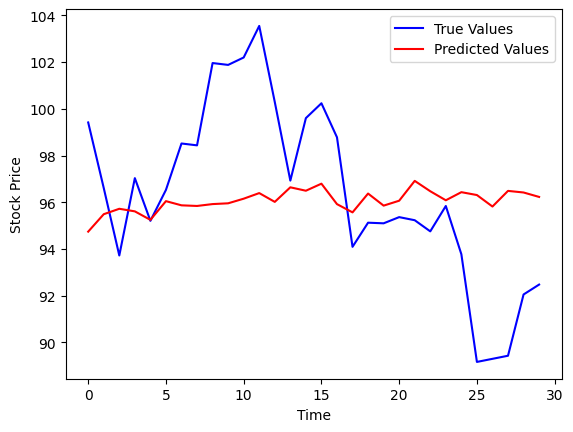

In [37]:
import matplotlib.pyplot as plt

# Plot the true values in blue
plt.plot(y_test.cpu().numpy()[6], color='blue', label='True Values')

# Plot the predicted values in red
plt.plot(y_pred.cpu().numpy()[6], color='red', label='Predicted Values')

# Add axis labels and a legend
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()

# Show the plot
plt.show()